# PIL -> get_characters

## Pre-processing

In [1]:
import os, json
from PIL import Image, ImageDraw, ImageFont,ImageFilter
import PIL.Image
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# Example of calling the function: get_glyph_img("上","STHeiti Medium.ttc",pt = 28)
# Return: numpy.ndarray
def get_glyph_img(character, fontname,
    pt = 256, binarize = True,
    descent_offset = True, offset=0):
    """Get image of a certain glyph from the given font
    Parameters
    ----------
    character: str
        The character to draw
    pt: int
        Number of pixels horizontally and vertically
    binarize: boolean
        Return a binary image or not
    fontname: str
        The font file name
    
    Returns
    ----------
    glyph_img: numpy.ndarray
        A greyscale image of the glyph, with its foreground in white (255) and
        background in black (0). 
    """
    width = height = pt
    font = ImageFont.truetype(fontname, pt)  # the size of the char is pt
    
    _, descent = font.getmetrics()
#     start = -descent+offset if descent_offset else 0
    start = offset if descent_offset else 0
    img = PIL.Image.new('L', (pt, pt), 0)
    draw = ImageDraw.Draw(img)
    draw.text((0, start), character, 255, font = font)
    img_array = np.array(img, dtype = np.uint8)
    if not binarize: return img_array
    else: return (img_array > 128).astype(np.uint8)
    
#     ascent, descent = font.getmetrics()
#     (font_width, font_height), (offset_x, offset_y) = font.font.getsize(character)
#     img = Image.new('L', (width, height), 0)   # set up the background with size pt*pt
#     draw = ImageDraw.Draw(img)
#     draw.text((width/2-(font_width/2+offset_x),height/2-(font_height/2+offset_y)) ,character, fill=255,font=font)
# #     draw.text(((width-font_width)/2-offset_x/2, (height-font_height)/2-offset_y/2-descent/2), character, fill=255,font=font) # draw character
#     img.show()
#     return img

In [3]:
def descent_offset(pt, fontname,characters):
    # calculate the offset needed to set the character in the middle of the graph
    res = np.zeros(len(characters))
    width = height = pt
    font = ImageFont.truetype(fontname, pt)  # the size of the char is pt
    for i in range (len(characters)):
        (font_width, font_height), (offset_x, offset_y) = font.font.getsize(characters[i])
        res[i] = height/2-(font_height/2+offset_y)
    
    return np.mean(res)

In [4]:
sentence = ''
pt = 28 # global variable defination ------------------------!!!!!!!!!!!!-----------------------------
for line in open('./common-standard-chinese-characters-table-master/level-1.txt','r'):
    rs = line.replace('\n','')
    sentence =sentence + rs
for line in open('./common-standard-chinese-characters-table-master/level-2.txt','r'):
    rs = line.replace('\n','')
    sentence =sentence + rs
    
sentence = sentence[20:50]
print('The length of the sentence is {}'.format(len(sentence)))

The length of the sentence is 30


In [5]:
def npz_char(pt = 28, fontname1 = "Songti.ttc", fontname2 = "STHeiti Medium.ttc"):
    # sentence --> the list of characters
    global sentence
    sentence_train = sentence
    print('The length of the sentence_train is {}'.format(len(sentence_train)))
    
    sentence_train = list(sentence_train)
    # delete same elements in the list
    dic_train={}
    characters_train = list(dic_train.fromkeys(sentence_train).keys())
    # Determine descent_offset for both fonts 
    offset1 = descent_offset(pt,fontname1,characters_train)
    print("For {}, the offset is {}".format(fontname1,offset1))
    offset2 = descent_offset(pt,fontname2,characters_train)
    print("For {}, the offset is {}".format(fontname2,offset2))
    
    # Training set #
    num_chars_train = len(characters_train)
    font1_chars_train = np.zeros((num_chars_train, pt*pt),dtype = np.uint8)  # (num_chars, 784)
    font2_chars_train = np.zeros((num_chars_train, pt*pt),dtype = np.uint8)  # (num_chars, 784)
    
    for i in range(num_chars_train):
        font1_chars_train[i] = get_glyph_img(characters_train[i], fontname1, pt = pt, binarize = True, offset = offset1).flatten()
        font2_chars_train[i] = get_glyph_img(characters_train[i], fontname2, pt = pt, binarize = True, offset = offset2).flatten()
    
    # Valid set #
    # PS: select the Validing Set from Training Set
    idx = np.random.choice(range(len(sentence_train)), size =len(sentence_train)//5, replace=False)
#     idx = np.random.choice(range(2000), size =len(sentence_train)//5, replace=False)
    idx.sort()
    sentence_valid = list(sentence[i] for i in idx)
    print('The length of the sentence_valid is {}'.format(len(sentence_valid)))
    sentence_valid = ''.join(sentence_valid)
    sentence_valid = list(sentence_valid)
#     print(sentence_valid)
    dic_valid={}
    characters_valid = list(dic_valid.fromkeys(sentence_valid).keys()) # delete same elements in the list
    num_chars_valid = len(characters_valid)
    font1_chars_valid = np.zeros((num_chars_valid, pt*pt),dtype = np.uint8)  # (num_chars, 784)
    font2_chars_valid = np.zeros((num_chars_valid, pt*pt),dtype = np.uint8)  # (num_chars, 784)
    
    for i in range(num_chars_valid):
        # .flatten 28*28->784
        font1_chars_valid[i] = get_glyph_img(characters_valid[i], fontname1, pt = pt, binarize = True, offset = offset1).flatten()
        font2_chars_valid[i] = get_glyph_img(characters_valid[i], fontname2, pt = pt, binarize = True, offset = offset2).flatten()
    # Testing set
    # Not used until now
    
    # Save the data
    np.savez('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data.npz', \
             X_train = font1_chars_train, y_train = font2_chars_train, \
             X_valid = font1_chars_valid, y_valid = font2_chars_valid)
    return

In [6]:
npz_char(pt = pt, fontname1 = "Songti.ttc", fontname2 = "STHeiti Medium.ttc")

The length of the sentence_train is 30
For Songti.ttc, the offset is -5.683333333333334
For STHeiti Medium.ttc, the offset is -1.2833333333333334
The length of the sentence_valid is 6


#### try to load from the npz file 

In [7]:
data = np.load('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data.npz')

define the pt = 28


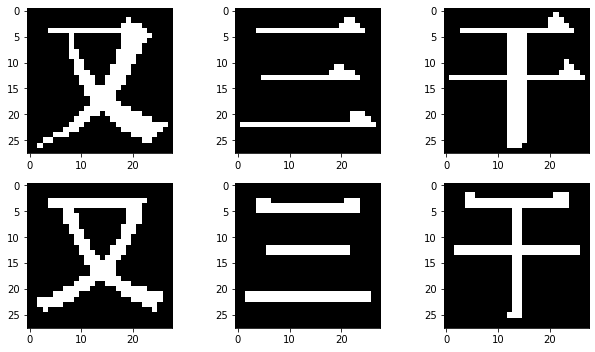

In [8]:
print("define the pt = {}".format(pt))
plt.figure(figsize=(9, 5)) 
# idx = np.random.choice(np.arange(6600))
plt.subplot(231); plt.imshow(data['X_train'][0].reshape(pt,pt),"gray" )
plt.subplot(234); plt.imshow(data['y_train'][0].reshape(pt,pt),"gray" )

plt.subplot(232); plt.imshow(data['X_train'][1].reshape(pt,pt),"gray" )
plt.subplot(235); plt.imshow(data['y_train'][1].reshape(pt,pt),"gray" )

plt.subplot(233); plt.imshow(data['X_train'][2].reshape(pt,pt),"gray" )
plt.subplot(236); plt.imshow(data['y_train'][2].reshape(pt,pt),"gray" )
plt.tight_layout()
plt.show()

# Pre-processing Finished -> AE_CNN

### Import and Pre-process the Data (data.nzp file with {'X_train': _____ , 'y_train': _____ , 'X_valid': _____ , 'y_valid': _____ })

In [24]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.__version__


'1.14.0'

In [10]:
data = np.load('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data.npz')
print('Shape of train_A:', data['X_train'].shape) # there are 6500 Songti characters for training, with shape (34,784)
print('Shape of train_B:', data['y_train'].shape) # there are 6500 STHeiti Medium for training, with shape (34,784)

print(data['X_train'][0].shape)

train_A = data['X_train'].astype("int8")
train_B = data['y_train'].astype("int8")
# mess up the order
# train_A, train_B = shuffle(train_A, train_B, random_state = 1234) 

valid_A = data['X_valid'].astype("int8")
valid_B = data['y_valid'].astype("int8")
# valid_A, valid_B = shuffle(valid_A, valid_B, random_state = 1234)

print('Shape of train_A and train_B:', train_A.shape)
print('Shape of valid_A and valid_B:', valid_A.shape)

Shape of train_A: (30, 784)
Shape of train_B: (30, 784)
(784,)
Shape of train_A and train_B: (30, 784)
Shape of valid_A and valid_B: (6, 784)


### Building the model

In [18]:
from tensorflow.contrib.layers import fully_connected
from tensorflow.python.ops.nn import relu, sigmoid

In [22]:
# define in/output size
num_features = train_A.shape[1]
print("num_features:", num_features)
# reset graph
reset_default_graph()

# # define the model_1
# A = tf.placeholder(tf.float32, [None, num_features], 'A')
# B = tf.placeholder(tf.float32, [None, num_features], 'B')
# l_enc = fully_connected(inputs=A, num_outputs=128, activation_fn=relu, scope='l_enc')
# l_z = fully_connected(inputs=l_enc, num_outputs=2, activation_fn=None, scope='l_z') # None indicates a linear output.
# l_dec = fully_connected(inputs=l_z, num_outputs=128, activation_fn=relu, scope='l_dec')
# A_hat = fully_connected(inputs=l_dec, num_outputs=num_features, activation_fn=sigmoid) # iid pixel intensities between 0 and 1.

# define the model_2
A = tf.placeholder(tf.float32, [None, num_features], 'A')
B = tf.placeholder(tf.float32, [None, num_features], 'B')
enc_1 = fully_connected(inputs=A, num_outputs=128, activation_fn=relu, scope='enc_1')
enc_2 = fully_connected(inputs=enc_1, num_outputs=32, activation_fn=relu, scope='enc_2')
l_z = fully_connected(inputs=enc_2, num_outputs=4, activation_fn=None, scope='l_z') # None indicates a linear output.
dec_2 = fully_connected(inputs=l_z, num_outputs=32, activation_fn=relu, scope='dec_2')
dec_1 = fully_connected(inputs=dec_2, num_outputs=128, activation_fn=relu, scope='dec_1')
A_hat = fully_connected(inputs=dec_1, num_outputs=num_features, activation_fn=sigmoid) # iid pixel intensities between 0 and 1.


# calculate loss
# loss_per_pixel = tf.square(tf.subtract(A_hat, B))
loss_per_pixel = tf.square(tf.subtract(A_hat,  B))
loss = tf.reduce_mean(loss_per_pixel, name="mean_square_error")

# define our optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)

# make training op for applying the gradients
train_op = optimizer.minimize(loss)

num_features: 784


Following we define the TensorFlow functions for training and evaluation.

In [23]:
# test the forward pass
_A_test = np.zeros(shape=(32, num_features))
_B_targets = np.zeros(shape=(32, num_features))
# initialize the Session
sess = tf.Session()
# test the forward pass
sess.run(tf.initialize_all_variables())
feed_dict = {A: _A_test, B: _B_targets}
res_forward_pass = sess.run(fetches=[A_hat, loss], feed_dict=feed_dict)
print("A_hat", res_forward_pass[0].shape)
print(loss)
# in this case, the learned arguments are all zero

A_hat (32, 784)
Tensor("mean_square_error:0", shape=(), dtype=float32)


# Running the Model

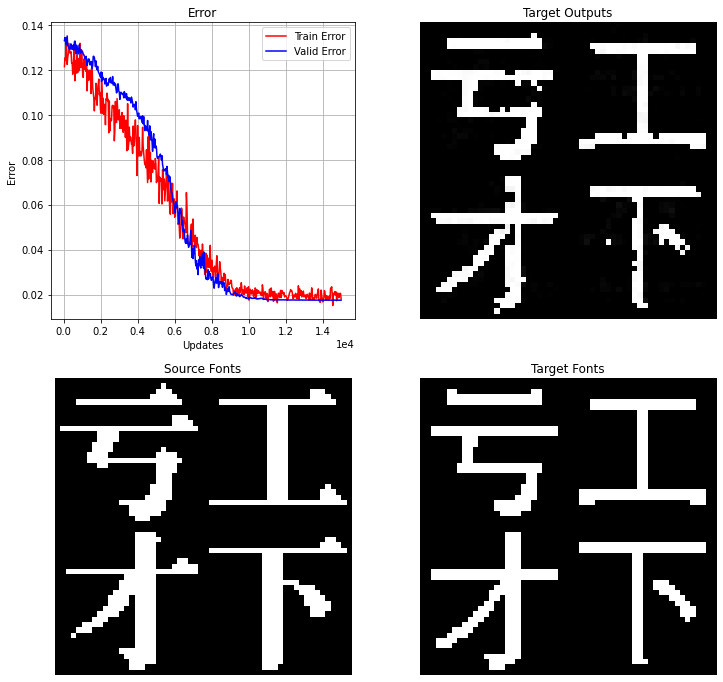

In [26]:
batch_size = 1
num_epochs = 500
num_samples_train = train_A.shape[0] # 3500 #30
num_batches_train = num_samples_train // batch_size
# num_samples_valid = valid_A.shape[0] # 1000 #6
# num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
reset_default_graph()
plt.figure(figsize=(12, 12))

num_char_dim = 2
# global variable pt = 256 is defined in Pre-processing[4]

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(train_A.shape[0]), size=(batch_size), replace=False)    
            x_A_batch = train_A[idxs]
            x_B_batch = train_B[idxs]
            # setup what to fetch, notice l
            fetches_train = [train_op, loss, A_hat, l_z]
            feed_dict_train = {A: x_A_batch, B: x_B_batch}    # --------------------
            # do the complete backprob pass
            res_train = sess.run(fetches_train, feed_dict_train)
            _, batch_loss, train_out, train_z = tuple(res_train)
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)] # batch_size*num_batches_train =num_samples_train

        # Evaluate     # train_op not used for optimizing!!!
        fetches_eval = [loss, A_hat, l_z]
        ##################### select the valid set #####################
        feed_dict_eval = {A: valid_A, B: valid_B}      # -----------------------
        res_valid = sess.run(fetches_eval, feed_dict_eval)       
        eval_loss, eval_out, eval_z = tuple(res_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(2,2,1)
        plt.cla() # clear the plot on the this(current) figure
        plt.title('Error')
        plt.xlabel('Updates'); plt.ylabel('Error')
        plt.plot(updates, train_loss, color="red")
        plt.plot(updates, valid_loss, color="blue")
        plt.legend(['Train Error', 'Valid Error'])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(2,2,2)
        plt.cla()
        plt.title("Target Outputs")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = eval_out[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
        
        plt.subplot(2,2,3)
        plt.cla()
        plt.title("Source Fonts")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = valid_A[idx].reshape((pt, pt))
#                 canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_A[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
                
        plt.subplot(2,2,4)
        plt.cla()
        plt.title("Target Fonts")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = valid_B[idx].reshape((pt, pt))
#                 canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_B[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
        
        filename = "1111output_epoch" + str(num_epochs) + "_pt" + str(pt) + ".png"
        plt.savefig(filename)
        display(Image(filename=filename))
        
#         plt.savefig("output.png")
#         display(Image(filename="output.png"))
        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [15]:
print(A_hat.shape)

(?, 784)


In [16]:
print(np.mean(np.square(train_A[-1]-train_A[-2])))
print(np.mean(np.square(train_A[-1]-train_B[-1])))

0.35714285714285715
0.1747448979591837


### draft

In [17]:
img_array = np.array(res, dtype = np.uint8)
print(img_array.dtype.name)

print(font.getmask('H').getbbox())
print(font.font.getsize('H'))

pt = width = height = 1024
font = ImageFont.truetype("Arial.ttf", pt)
ascent, descent = font.getmetrics()
print(ascent,descent)
(font_width, font_height), (offset_x, offset_y) = font.font.getsize('A')
print(font.font.getsize("A"))
img = Image.new('L', (width, height),0)
print(width,height)
draw = ImageDraw.Draw(img)

draw.text((width/2-(font_width/2+offset_x),height/2-(font_height/2+offset_y)) ,"A", fill=255,font=font)

# draw.text(((width-font_width)/2-offset_x/2, (height-font_height)/2-offset_y/2-descent/2), "A", fill=255,font=font)
img.show()

NameError: name 'res' is not defined

In [ ]:
#plot a few  examples
plt.figure(figsize=(15, 25)) # (width, height)

idx = 0
canvas = np.zeros((pt*10, 10*pt))
for i in range(10):
    for j in range(10):
        canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_A[idx].reshape((pt, pt))
        idx += 1
plt.subplot(121).set_title('Songti characters')
plt.axis('off')
plt.imshow(canvas, cmap='gray')

idx = 0
canvas = np.zeros((pt*10, 10*pt))
for i in range(10):
    for j in range(10):
        canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_B[idx].reshape((pt, pt))
        idx += 1
plt.subplot(122).set_title('STHeiti Medium')
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.show()

In [ ]:
# # testing1 
# valid_A[:] = train_A[3]
# valid_B[:] = train_B[3]
# plt.imshow(valid_A[0].reshape(28,28),cmap='gray')
# plt.show()
# plt.imshow(valid_B[0].reshape(28,28),cmap='gray')
# plt.show()

# k=5
# size = train_A.shape[0]//k
# train_A[size*k:]= train_A[k-1] 
# train_B[size*k:]= train_B[k-1] 
# for i in range (k-1,0,-1):
#     train_A[size*(i-1): size*i] = train_A[i-1]
#     train_B[size*(i-1): size*i] = train_B[i-1]
    
# print("showing...")
# plt.imshow(train_A[0].reshape(28,28),cmap='gray')
# plt.show()
# plt.imshow(train_B[0].reshape(28,28),cmap='gray')
# plt.show()
# plt.imshow(train_A[102].reshape(28,28),cmap='gray')
# plt.show()
# plt.imshow(train_B[102].reshape(28,28),cmap='gray')
# plt.show()


In [ ]:
import os

In [ ]:
print(os.path.dirname(os.path.abspath(__file__)))

In [ ]:
filename = "output_epoch" + str(num_epochs) + "_pt" + str(pt) + ".png"
print(filename)